<a href="https://colab.research.google.com/github/Abhishek-k03/Brain-Tumor-Detection-using-CNN/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.11.11


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [3]:
# directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI images/Training'
test_dir = '/content/drive/MyDrive/MRI images/Testing'

In [4]:
# load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [5]:
# load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

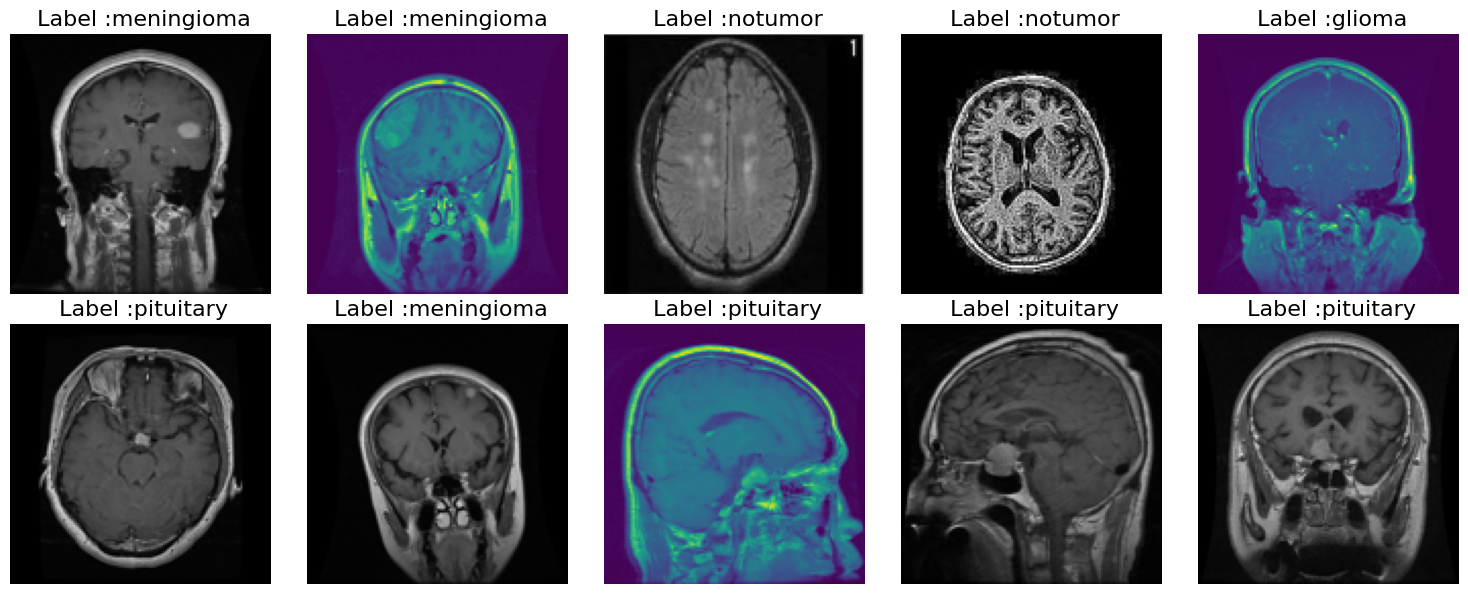

In [6]:
import random
import matplotlib.pyplot as plt

# select random indices for 10 images
random_indices = random.sample(range(len(train_paths)),10)

# creating a figure to display images in 2 rows
fig, axes = plt.subplots(2,5, figsize = (15,6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128,128))
  axes[i].imshow(img)
  axes[i].axis("off")
  axes[i].set_title(f" Label :{train_labels[idx]}", fontsize = 16)

plt.tight_layout()
plt.show()

## Image Preprocessing functions

In [7]:
# Image Augmentation function
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image

# Load images and apply augmentation
def open_images(paths):
  images=[]
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE, 3))
    img = augment_image(img)
    images.append(img)
  return np.array(images)

# Encoder Labels
def encode_labels(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

# Data Generator for Batching
def datagen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range(0,len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_labels(batch_labels)
      yield batch_images, batch_labels

In [8]:
# model architecture (128,128,3)
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top = False, weights='imagenet')

# Freeze all layers of the vgg16 base model
for layer in base_model.layers:
  layer.trainable = False

# Set only the last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

# Build Model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))) # Input layer
model.add(base_model) # VGG16 model
model.add(Flatten()) # Flatten layer
model.add(Dropout(0.3)) # Dropout layer
model.add(Dense(128, activation='relu')) # Dense layer
model.add(Dropout(0.2)) # Dropout layer
model.add(Dense(len(os.listdir(train_dir)), activation='softmax')) # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5


# train model
history = model.fit(
    datagen(train_paths, train_labels, batch_size= batch_size, epochs=epochs),
    epochs= epochs, steps_per_epoch = steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 3048s 11s/step - loss: 0.6563 - sparse_categorical_accuracy: 0.7284
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - loss: 0.2566 - sparse_categorical_accuracy: 0.9041
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.9373
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - loss: 0.1128 - sparse_categorical_accuracy: 0.9587
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9672


## Training and val plots

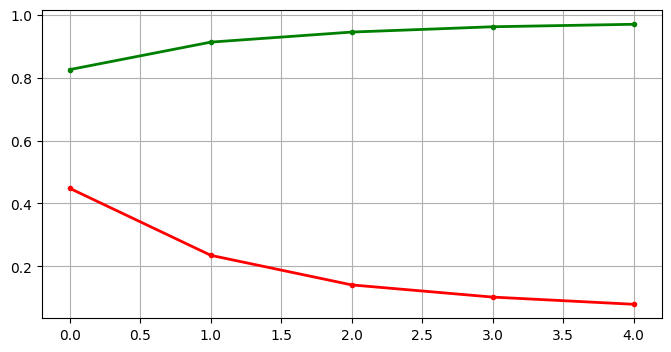

In [9]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'.g-', linewidth=2)
plt.plot(history.history['loss'],'.r-', linewidth=2)

## Model Classification Report

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
import seaborn as sns
from sklearn.preprocessing import label_binarize

test_images = open_images(test_paths)
test_labels_encoded = encode_labels(test_labels)

test_predictions = model.predict(test_images)
print("Classification Report: ")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis =1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       300
           1       1.00      0.99      0.99       405
           2       0.95      0.90      0.92       306
           3       0.95      0.95      0.95       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



## Model Confusion Plot

Confusion Matrix: 


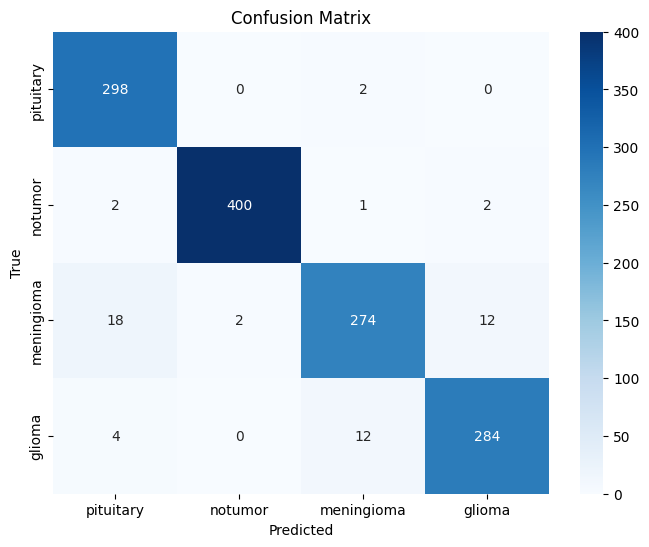

In [11]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis =1))
print("Confusion Matrix: ")

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Save and Load the model

In [12]:
# Save the entire model
model.save('model.h5')

In [13]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

## Evaluate the model

In [14]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))